Training Data Shape: (50000, 3, 32, 32)
Training Labels Shape: (50000,)
Sample Label: frog


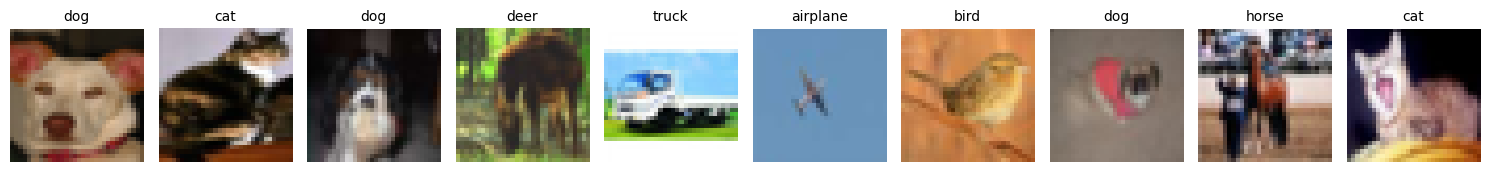

In [1]:
# STEP 1: CIFAR-10 Raw File Loader and Visualizer (PyTorch Compatible)

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

# === PATH SETUP ===
# Change this to the folder where your CIFAR-10 raw batch files are located
DATA_DIR = './CIFAR'

# === UTILITY FUNCTION TO UNPICKLE CIFAR FILES ===
def unpickle(file_path):
    with open(file_path, 'rb') as f:
        # Use 'latin1' encoding for compatibility with Python 3
        data_dict = pickle.load(f, encoding='latin1')
    return data_dict

# === LOAD LABEL NAMES FROM META FILE ===
def load_label_names():
    meta = unpickle(os.path.join(DATA_DIR, 'batches.meta'))
    label_names = meta['label_names']
    return label_names

# === LOAD SINGLE DATA BATCH (e.g., data_batch_1) ===
def load_cifar_batch(file_path):
    batch = unpickle(file_path)
    data = batch['data']               # shape: (10000, 3072)
    labels = batch['labels']          # list of 10000 integers
    filenames = batch['filenames']    # list of filenames

    # Convert to (num_samples, 3, 32, 32)
    data = data.reshape(-1, 3, 32, 32).astype("uint8")
    return data, labels, filenames

# === LOAD ALL TRAINING BATCHES TOGETHER ===
def load_all_training_batches():
    train_data = []
    train_labels = []
    train_filenames = []

    for i in range(1, 6):  # data_batch_1 to data_batch_5
        batch_path = os.path.join(DATA_DIR, f'data_batch_{i}')
        data, labels, filenames = load_cifar_batch(batch_path)
        train_data.append(data)
        train_labels += labels
        train_filenames += filenames

    # Stack all batches into a single array
    train_data = np.concatenate(train_data, axis=0)
    train_labels = np.array(train_labels)

    return train_data, train_labels, train_filenames

# === VISUALIZE SAMPLE IMAGES FROM THE BATCH ===
def show_sample_images(data, labels, label_names, num_samples=10):
    plt.figure(figsize=(15, 3))
    indices = np.random.choice(len(data), num_samples, replace=False)

    for i, idx in enumerate(indices):
        img = data[idx].transpose(1, 2, 0)  # Convert (C, H, W) to (H, W, C)
        label = label_names[labels[idx]]

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(label, fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# === MAIN LOADING + VISUALIZATION ===

if __name__ == "__main__":
    label_names = load_label_names()
    train_data, train_labels, train_filenames = load_all_training_batches()

    print("Training Data Shape:", train_data.shape)
    print("Training Labels Shape:", train_labels.shape)
    print("Sample Label:", label_names[train_labels[0]])

    show_sample_images(train_data, train_labels, label_names, num_samples=10)


In [2]:
import numpy as np
import torch

def compute_dataset_mean_std(images):
    """
    images: numpy array of shape (N, 3, 32, 32) in uint8
    returns: mean and std per channel (as list of 3 floats)
    """
    images = images.astype(np.float32) / 255.0  # Scale to [0,1]
    images_tensor = torch.from_numpy(images)    # shape: (N, 3, 32, 32)

    # Reshape: (N, C, H, W) → (C, N * H * W)
    channels = images_tensor.view(3, -1)
    mean = channels.mean(dim=1).tolist()
    std = channels.std(dim=1).tolist()

    return mean, std

# Usage:
computed_mean, computed_std = compute_dataset_mean_std(train_data)
print("Computed Mean:", computed_mean)
print("Computed Std:", computed_std)


Computed Mean: [0.4741103947162628, 0.4726613759994507, 0.4733172357082367]
Computed Std: [0.25205469131469727, 0.25201529264450073, 0.250632107257843]


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms

# === CIFAR-10 normalization constants ===
CIFAR10_MEAN =  [0.4741103947162628, 0.4726613759994507, 0.4733172357082367]
CIFAR10_STD  =  [0.25205469131469727, 0.25201529264450073, 0.250632107257843]

# === Custom Dataset for Raw CIFAR-10 ===
class CIFAR10RawDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images  # shape: (N, 3, 32, 32)
        self.labels = labels  # shape: (N,)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = torch.tensor(image, dtype=torch.uint8)
        label = torch.tensor(label, dtype=torch.long)  # <-- THIS FIX

        if self.transform:
            image = self.transform(image)

        return image, label


# === Transform: Normalize & Convert ===
# This transforms a uint8 image into a float tensor with normalization
transform = transforms.Compose([
    transforms.ConvertImageDtype(torch.float),  # Converts [0-255] → [0.0-1.0]
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)  # Normalizes with mean/std
])

# === Load raw data from Step 1 ===
# Assume `train_data`, `train_labels` already loaded from step 1
dataset = CIFAR10RawDataset(train_data, train_labels, transform=transform)

# === Optional: Train / Validation Split ===
train_size = int(0.9 * len(dataset))  # 45k train
val_size = len(dataset) - train_size # 5k val
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

sample = train_dataset[0]
print(sample[0].shape, sample[1])


# === Create DataLoaders ===
BATCH_SIZE = 128

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

# === CUDA Check ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# === Sanity Check: One batch ===
def inspect_batch(data_loader, label_names):
    images, labels = next(iter(data_loader))
    print("Batch image shape:", images.shape)
    print("Batch label shape:", labels.shape)
    print("Sample label:", label_names[labels[0]])

    # Reverse normalize and plot one image
    img = images[0].cpu()
    for i in range(3):
        img[i] = img[i] * CIFAR10_STD[i] + CIFAR10_MEAN[i]
    img = img.permute(1, 2, 0).numpy()

    import matplotlib.pyplot as plt
    plt.imshow(img)
    plt.title(label_names[labels[0]])
    plt.axis("off")
    plt.show()

# Run this if you want to preview a batch
# inspect_batch(train_loader, label_names)


torch.Size([3, 32, 32]) tensor(0)
Using device: cuda


In [4]:
# # Basic CNN Model for CIFAR-10 Classification
# # This model is designed to work with the CIFAR-10 dataset and includes convolutional layers

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# from tqdm import tqdm

# # === CNN MODEL ===
# class CustomCNN(nn.Module):
#     def __init__(self, num_classes=10):
#         super(CustomCNN, self).__init__()
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(3, 32, kernel_size=3, padding=1),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.MaxPool2d(2)  # 32x32 → 16x16
#         )
#         self.conv2 = nn.Sequential(
#             nn.Conv2d(32, 64, kernel_size=3, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.MaxPool2d(2)  # 16x16 → 8x8
#         )
#         self.conv3 = nn.Sequential(
#             nn.Conv2d(64, 128, kernel_size=3, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#             nn.AdaptiveAvgPool2d((1, 1))  # 8x8 → 1x1
#         )
#         self.fc1 = nn.Linear(128, 64)
#         self.fc2 = nn.Linear(64, num_classes)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.conv3(x)
#         x = x.view(x.size(0), -1)  # Flatten
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

# # === TRAINING + VALIDATION LOOP ===
# def train_model(model, train_loader, val_loader, device, epochs=10, lr=0.001):
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=lr)

#     model = model.to(device)

#     for epoch in range(epochs):
#         print(f"\nEpoch {epoch+1}/{epochs}")
#         model.train()
#         train_loss, correct, total = 0.0, 0, 0

#         progress_bar = tqdm(train_loader, desc="Training", leave=False)
#         for inputs, labels in progress_bar:
#             inputs, labels = inputs.to(device), labels.to(device)

#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             train_loss += loss.item() * inputs.size(0)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#             progress_bar.set_postfix(loss=loss.item(), acc=100 * correct / total)

#         train_acc = 100 * correct / total
#         train_loss /= total
#         print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")

#         # === VALIDATION ===
#         model.eval()
#         val_loss, correct, total = 0.0, 0, 0
#         with torch.no_grad():
#             for inputs, labels in val_loader:
#                 inputs, labels = inputs.to(device), labels.to(device)
#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels)

#                 val_loss += loss.item() * inputs.size(0)
#                 _, predicted = torch.max(outputs.data, 1)
#                 total += labels.size(0)
#                 correct += (predicted == labels).sum().item()

#         val_acc = 100 * correct / total
#         val_loss /= total
#         print(f"Val  Loss: {val_loss:.4f}, Val  Accuracy: {val_acc:.2f}%")

#     return model

# # === USAGE ===

# model = CustomCNN(num_classes=10)
# trained_model = train_model(model, train_loader, val_loader, device, epochs=10, lr=0.001)

# # === SAVE MODEL ===
# torch.save(trained_model.state_dict(), "cnn_cifar10.pth")


In [ ]:
# STEP 3: ResNet-18 model Fine-tuning on CIFAR-10

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

# === ResNet-18 transforms ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet mean
                         [0.229, 0.224, 0.225])  # ImageNet std
])

# === Dataset using your raw data ===
class CIFAR10ResizedDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.tensor(self.images[idx], dtype=torch.uint8)
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, label

# === Split your dataset ===
dataset = CIFAR10ResizedDataset(train_data, train_labels, transform=transform)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)

# === Load ResNet-18 ===
model = torchvision.models.resnet18(pretrained=True)

# Replace final layer
model.fc = nn.Linear(model.fc.in_features, 10)  # CIFAR-10 has 10 classes
model = model.to('cuda')

# === Optimizer and Loss ===
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# === Training loop ===
def train_model(model, train_loader, val_loader, device='cuda', epochs=20):
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            loop.set_postfix(loss=loss.item(), acc=100. * correct / total)

        print(f"Train Acc: {100. * correct / total:.2f}%, Loss: {total_loss / total:.4f}")

        # Validation
        model.eval()
        val_correct, val_total, val_loss = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        print(f"Val Acc: {100. * val_correct / val_total:.2f}%, Loss: {val_loss / val_total:.4f}")

    return model

# === Train it ===
trained_model = train_model(model, train_loader, val_loader, device='cuda', epochs=5)

# === Save model ===
torch.save(trained_model.state_dict(), "resnet18_cifar10_best.pth")


c:\Users\Tilak Devi\anaconda3\envs\main\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Tilak Devi\anaconda3\envs\main\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/5:  39%|███▉      | 278/704 [06:05<09:31,  1.34s/it, acc=84.2, loss=0.26] 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np


In [ ]:
def evaluate_model(model, data_loader, class_names):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to('cuda')
            labels = labels.to('cuda')
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)

            all_preds.extend(torch.argmax(probs, dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_preds), np.array(all_labels), np.array(all_probs)


In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

preds, labels, probs = evaluate_model(trained_model, val_loader, class_names)


In [ ]:
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(labels, preds, target_names=class_names))


In [ ]:
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Binarize labels for ROC
labels_bin = label_binarize(labels, classes=range(10))

fpr, tpr, roc_auc = {}, {}, {}
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC for each class
plt.figure(figsize=(12, 8))
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve (One-vs-Rest)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()


In [ ]:
def show_misclassified(images, labels, preds, class_names, max_images=12):
    wrong = np.where(labels != preds)[0]
    print(f"Total misclassified: {len(wrong)}")
    if len(wrong) == 0:
        return

    indices = np.random.choice(wrong, size=min(max_images, len(wrong)), replace=False)
    plt.figure(figsize=(15, 8))
    for i, idx in enumerate(indices):
        img, true_label, pred_label = images[idx], labels[idx], preds[idx]
        img = img.permute(1, 2, 0).cpu().numpy()
        img = img * 0.229 + 0.485  # Unnormalize
        plt.subplot(3, 4, i+1)
        plt.imshow(img.clip(0, 1))
        plt.title(f'True: {class_names[true_label]}\nPred: {class_names[pred_label]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:
# Re-run inference and cache images
wrong_imgs = []
wrong_labels = []
wrong_preds = []

trained_model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        outputs = trained_model(images.to('cuda'))
        preds_batch = outputs.argmax(dim=1).cpu()
        wrong_mask = preds_batch != labels
        if wrong_mask.any():
            wrong_imgs.append(images[wrong_mask])
            wrong_labels.append(labels[wrong_mask])
            wrong_preds.append(preds_batch[wrong_mask])

wrong_imgs = torch.cat(wrong_imgs)
wrong_labels = torch.cat(wrong_labels)
wrong_preds = torch.cat(wrong_preds)

show_misclassified(wrong_imgs, wrong_labels, wrong_preds, class_names)
